# Simulation numérique de la précession nodale de l'ISS

## Calcul du potentiel gravitationnel

Dans le référentiel géocentrique, le satellite a une position repérée par ses coordonnées $X$, $Y$ et $Z$, le plan de référence (coordonnées  $X$ et $Y$) étant le plan équatorial. Dans ce référentiel, $\lambda$ est la latitude ou la déclinaison. On note par ailleurs $R=\sqrt{X^2+Y^2+Z^2}$ et $\mu_T$ le paramètre gravitationnel standard de la Terre. Pour une Terre sphérique, le potentiel gravitationnel est :

$$V(R,\lambda)=-\dfrac{\mu_T}{R}$$

Il en résulte une accélération qui détermine un mouvement classique sur une orbite de Kepler.

$$-\dfrac{\mu_T}{R^3}
\begin{pmatrix}
X\\
Y\\
Z
\end{pmatrix}$$

Pour une Terre ellipsoïdale avec un rayon moyen $R_T=6371 \text{ km}$, on modélise approximativement le potentiel gravitationnel avec un terme complémentaire au précédent ($J_2 = 1,082625\times10^{−3}$).

$$V(R,\lambda)=-\dfrac{\mu_T}{R}\left(1-\dfrac{J_2}{2}\left(\dfrac{R_T}{R}\right)^2(3\sin^2(\lambda)-1)\right)$$

Un terme complémentaire apparaît alors pour l'accélération, dont la direction ne passe plus par le centre de la Terre.

$$\dfrac{3}{2}J_2\mu_T\left(\dfrac{R_T}{R}\right)^2
\begin{pmatrix}
\left(\dfrac{X}{R^3}\right)\left(5\left(\dfrac{Z}{R}\right)^2-1\right)\\
\left(\dfrac{Y}{R^3}\right)\left(5\left(\dfrac{Z}{R}\right)^2-1\right)\\
\left(\dfrac{Z}{R^3}\right)\left(5\left(\dfrac{Z}{R}\right)^2-3\right)
\end{pmatrix}$$

Une conséquence bien visible de cette perturbation apparaît, avec la ligne des noeuds associée à l'orbite du satellite qui tourne dans le sens rétrograde. Il s'agit de la **précession nodale**.

L'objet du programme proposé est de simuler numériquement cet effet pour l'ISS, et de confronter les résultats aux données fournies par le JPL.

## Documents

https://fr.wikipedia.org/wiki/Pr%C3%A9cession_nodale

https://mecaspa.cannes-aero-patrimoine.net/COURS_SA/PARAMORB/Paramorb.htm

https://mecaspa.cannes-aero-patrimoine.net/COURS_SA/PERT_J2/J2.htm

https://ipag.osug.fr/~beusth/gravm2/gravm2.pdf (page 11, (1.27))

## Programmme

In [1]:
import numpy as np
from numpy.linalg import norm
from datetime import datetime
import pandas as pd
import requests as rq
import io
import matplotlib.pyplot as plt


# requête avec l'API du JPL
# id : identifiant de l'objet
# id='-125544' pour l'ISS
# debut,fin,pas : intervalle de temps sélectionné, et le pas temporel


def req_jpl_read(id='-125544', EPHEM_TYPE='VECTORS', VEC_TABLE='2', CENTER='500@399',
                 REF_PLANE='F', REF_SYSTEM='ICRF',
                 debut='2024-03-10 00:00:00', fin='2024-03-14 00:00:00', pas='1 m'):
    commande = 'https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND=\''+id +\
        '\'&OBJ_DATA=\'YES\'&MAKE_EPHEM=\'YES\'&EPHEM_TYPE=\''+EPHEM_TYPE +\
        '\'&VEC_TABLE=\''+VEC_TABLE+'\'&CSV_FORMAT=\'YES\'&CENTER=\''+CENTER +\
        '\'&REF_PLANE=\''+REF_PLANE+'\'&REF_SYSTEM=\''+REF_SYSTEM+'\'&START_TIME=\'' +\
        debut+'\'&STOP_TIME=\''+fin+'\'&STEP_SIZE=\''+pas+'\''
    print('Requête API JPL')
    print(commande)
    rep = rq.get(commande)
    # récupération et traitement du contenu en retour de la requête
    f = io.StringIO(rep.content.decode())
    lines = f.readlines()
    for line in lines:
        if line.find('$$SOE') != -1:
            debut = lines.index(line)
        if line.find('$$EOE') != -1:
            nlignes = lines.index(line)-debut-1
    f.close()
    # liste des lignes à ne pas prendre en compte
    skip = [n for n in range(0, debut-2)]
    skip.append(debut-1), skip.append(debut)
    # lecture du fichier de données
    f = io.StringIO(rep.content.decode())
    df = pd.read_csv(f, skiprows=skip, nrows=nlignes)
    f.close()
    # élimination de la dernière colonne qui est vide
    df = df.drop(df.columns[-1], axis=1)
    # format datetime pour les dates (en colonne 1)
    dates = pd.to_datetime(df.iloc[:, 1], format=' A.D. %Y-%b-%d %H:%M:%S.%f')
    df = df.drop(df.columns[1], axis=1)
    df.insert(1, 'DATES', dates)
    # noms des colonnes sans espace
    noms_col = [df.columns.values[n].strip()
                for n in range(len(df.columns.values))]
    df.columns = noms_col
    return df


# Méthode générique de résolution numérique d'équation différentielle ordinaire
# y'=f(t,y)
# (Runge-Kutta d'ordre 4)
# la fonction f est de la forme f(t,y)
# t est une liste d'instants sur lesquels s'effectue la résolution
# y0 est la condition initiale


def rk4(f, t, y0):
    y = np.zeros((len(t), len(y0)))
    k1 = np.zeros(len(y0))
    k2 = np.copy(k1)
    k3 = np.copy(k1)
    k4 = np.copy(k1)
    y[0, :] = y0[:]
    for n in np.arange(1, len(t)):
        yprec = y[n-1]
        tprec = t[n-1]
        h = t[n]-tprec
        k1[:] = f(tprec, yprec)
        k2[:] = f(tprec+h/2, yprec+(h/2)*k1)
        k3[:] = f(tprec+h/2, yprec+(h/2)*k2)
        k4[:] = f(tprec+h, yprec+h*k3)
        y[n, :] = yprec+(h/6)*(k1+2*k2+2*k3+k4)
    return t, y

# Méthode rk8
# (Runge-Kutta d'ordre 8)


def rk8(f, t, y0):
    y = np.zeros((len(t), len(y0)))
    k1 = np.zeros(len(y0))
    k2 = np.copy(k1)
    k3 = np.copy(k1)
    k4 = np.copy(k1)
    k5 = np.copy(k1)
    k6 = np.zeros(len(y0))
    k7 = np.copy(k1)
    k8 = np.copy(k1)
    k9 = np.copy(k1)
    k10 = np.copy(k1)
    y[0, :] = y0[:]
    for n in np.arange(1, len(t)):
        yprec = y[n-1]
        tprec = t[n-1]
        h = t[n]-tprec
        k1[:] = f(tprec, yprec)
        k2[:] = f(tprec+h*(4/27), yprec+(h*4/27)*k1)
        k3[:] = f(tprec+h*(2/9), yprec+(h/18)*(k1+3*k2))
        k4[:] = f(tprec+h*(1/3), yprec+(h/12)*(k1+3*k3))
        k5[:] = f(tprec+h*(1/2), yprec+(h/8)*(k1+3*k4))
        k6[:] = f(tprec+h*(2/3), yprec+(h/54)*(13*k1-27*k3+42*k4+8*k5))
        k7[:] = f(tprec+h*(1/6), yprec+(h/4320) *
                  (389*k1-54*k3+966*k4-824*k5+243*k6))
        k8[:] = f(tprec+h, yprec+(h/20) *
                  (-231*k1+81*k3-1164*k4+656*k5-122*k6+800*k7))
        k9[:] = f(tprec+h*(5/6), yprec+(h/288) *
                  (-127*k1+18*k3-678*k4+456*k5-9*k6+576*k7+4*k8))
        k10[:] = f(tprec+h, yprec+(h/820)*(1481*k1-81*k3 +
                   7104*k4-3376*k5+72*k6-5040*k7-60*k8+720*k9))
        y[n, :] = yprec+(h/840)*(41*k1+27*k4+272*k5+27*k6+216*k7+216*k9+41*k10)
    return t, y

# L'anomalie moyenne M permet d'obtenir l'anomalie excentrique
# (résolution itérative de l'équation de Kepler M=E-e*sin(E))


def eq_kepler(M, e):
    E = np.pi
    M = np.remainder(M, 2*np.pi)
    for n in range(5):
        E = (M-e*(E*np.cos(E)-np.sin(E)))/(1-e*np.cos(E))
    return E

# Calcul des paramètres orbitaux à partir de la position r et la vitesse V
# à chaque instant. Les paramètres r et V sont des tableaux à trois colonnes
# et un nombre de lignes correspondant aux instants de calcul.
# e : vecteur excentricité (pointe vers le périastre)
# i : inclinaison du plan de l'orbite osculatrice
# Omega : longitude du noeud ascendant
# omega : argument du périastre


def calc_param_orb(r, V, mu):
    I = np.array([1, 0, 0])
    J = np.array([0, 1, 0])
    K = np.array([0, 0, 1])
    h = np.cross(r, V)
    n = np.cross(K, h)
    e = np.cross(V, h)/mu-(r.T/norm(r, axis=1)).T
    test = np.sum(J*n, axis=1)
    Omega = (180/np.pi)*np.arccos(np.sum(I*n, axis=1)/norm(n, axis=1))
    Omega[test < 0] = 360-Omega[test < 0]
    i = (180/np.pi)*np.arccos(np.sum(K*h, axis=1)/norm(h, axis=1))
    test = np.sum(K*e, axis=1)
    omega = (180/np.pi)*np.arccos(np.sum(e*n, axis=1) /
                                  (norm(e, axis=1)*norm(n, axis=1)))
    omega[test < 0] = 360-omega[test < 0]
    return e, i, Omega, omega

# Calcul des élément permettant de décrire le mouvement sur une orbite de Kepler,
# à partir de la position r et la vitesse V à un instant donné.
# a : demi grand axe de l'ellipse en km
# e : vecteur excentricité  (pointe vers le périastre)
# T : période de l'orbite en secondes
# M0 : anomalie moyenne initiale
# CB : matrice de changement de base (P,Q,W) vers (I,J,K)


def calc_param_kepler(r, V, mu):
    h = np.cross(r, V)
    e = np.cross(V, h)/mu-r/norm(r)
    a = mu/(2*mu/norm(r)-norm(V)**2)
    T = 2*np.pi*np.sqrt(a**3/mu)
    W = h/norm(h)
    P = e/norm(e)
    Q = np.cross(W, P)
    CB = np.array([P, Q, W]).T
    cosE = (1-norm(r)/a)/norm(e)
    if cosE > 1.0:
        cosE = 1.0
    elif cosE < -1.0:
        cosE = -1.0
    E = np.arccos(cosE)
    test = np.sum(Q*r)
    if (test < 0):
        E = 2*np.pi-E
    M0 = E-norm(e)*np.sin(E)
    return a, e, T, M0, CB

# Calcul d'une orbite de Kepler pour les instants données
# dans le vecteur t.


def orbite_kepler(r, V, mu, t):
    a, e, T, M0, CB = calc_param_kepler(r, V, mu)
    # Génération de l'anomalie moyenne
    M = M0+2*np.pi*t/T
    # Génération de l'anomalie excentrique
    E = np.array([eq_kepler(M[n], norm(e)) for n in range(len(t))])
    # Génération de l'anomalie vraie
    theta = 2*np.arctan(np.sqrt((1+norm(e))/(1-norm(e)))*np.tan(E/2))
    # Rayon vecteur
    r = a*(1-norm(e)*np.cos(E))
    # Coordonnées du satellite dans le plan orbital (P,Q), repère (P,Q,W)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = np.zeros(len(t))
    xyz = np.concatenate(([x], [y], [z]))
    # Changement de base vers le repère géocentrique (I,J,K)
    XYZ = (CB@xyz).T
    return XYZ


def equ_dyn(y, mu, termeJ2=True):
    r = y[0:3]
    V = y[3:6]
    X = r[0]
    Y = r[1]
    Z = r[2]
    R = norm(r)
    yp = np.zeros(6)
    yp[0:3] = V
    yp[3:6] = -mu*r/R**3
    if termeJ2:
        RT = 6371
        J2 = 1.082625e-3
        yp[3:6] = yp[3:6] + (3/2)*J2*mu*(RT/R)**2 *\
            np.array([(X/R**3)*(5*(Z/R)**2-1),
                      (Y/R**3)*(5*(Z/R)**2-1),
                      (Z/R**3)*(5*(Z/R)**2-3)])
    return yp

# tracé en 3D d'une trajectoire relative (échelles en km)


def trace3D_traj(Astre, Sat, XYZ, RT):
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], 'b', label=Sat, lw=0.5)
    NC = 1000
    cercle = np.zeros((NC, 3))
    cercle[:, 0] = RT*np.cos(2*np.pi*np.arange(NC)/NC)
    cercle[:, 1] = RT*np.sin(2*np.pi*np.arange(NC)/NC)
    ax.plot3D(cercle[:, 0], cercle[:, 1], cercle[:, 2], c='r', label=Astre)
    ax.set_title('Trajectoire '+Sat+' (origine '+Astre+')')
    ax.set_xlabel('X (en km)'), ax.set_ylabel(
        'Y (en km)'), ax.set_zlabel('Z (en km)')
    ax.axis('equal')
    ax.legend()

# tracé en 3D de l'erreur sur la trajectoire (JPL vs. simulation)


def trace3D_err(Astre, Sat, XYZ_err):
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(XYZ_err[:, 0], XYZ_err[:, 1], XYZ_err[:, 2], 'b', lw=0.5)
    ax.set_title('Erreur sur la trajectoire '+Sat+' (origine '+Astre+')')
    ax.set_xlabel('X (en km)'), ax.set_ylabel(
        'Y (en km)'), ax.set_zlabel('Z (en km)')
    ax.axis('equal')


def trace2D(Astre, Sat, t, XYZ, RT):
    plt.figure()
    plt.plot(t, np.sqrt(XYZ[:, 0]**2 +
             XYZ[:, 1]**2+XYZ[:, 2]**2)-RT, 'b', lw=0.5)
    plt.title('Altitude '+Sat+' (origine '+Astre+')')
    plt.xlabel('temps (dates)'), plt.ylabel('altitude (en km)')
    plt.grid('on')

# tracé pour la comparaison des paramètres orbitaux obtenus par les méthodes a ou b


def trace_param_orb(Nature, Unite, Astre, Sat, param_a, param_b, label_a, label_b, dates_a, dates_b):
    plt.figure()
    plt.plot(dates_a, param_a, 'b', label=label_a, lw=0.5)
    plt.plot(dates_b, param_b, 'r', label=label_b, lw=0.5)
    plt.title(Nature+' '+Sat+' (origine '+Astre+')')
    plt.xlabel('temps (dates)')
    plt.ylabel(Unite)
    plt.legend()
    plt.grid('on')


## Paramètres

Les calculs vont se faire sur 4 jours, avec un pas de une minute.

In [2]:
id='-125544'
debut='2024-03-10,00:00:00'
fin='2024-03-14,00:00:00'
pas='1m'
mu=398600.435507
RT=6371
meth=rk8

## Récupération et visualisation des données du JPL pour l'ISS

Après récupération des données du JPL, on observe bien une précession du plan de l'orbite.

Requête API JPL
https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND='-125544'&OBJ_DATA='YES'&MAKE_EPHEM='YES'&EPHEM_TYPE='VECTORS'&VEC_TABLE='2'&CSV_FORMAT='YES'&CENTER='500@399'&REF_PLANE='F'&REF_SYSTEM='ICRF'&START_TIME='2024-03-10,00:00:00'&STOP_TIME='2024-03-14,00:00:00'&STEP_SIZE='1m'


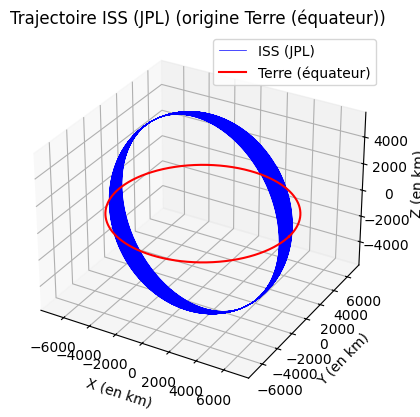

In [3]:
# Récupération des données JPL
df = req_jpl_read(id=id, debut=debut, fin=fin, pas=pas)
# Liste des instants commune à tous les calculs
t = np.array([pd.to_timedelta(df.loc[k, 'DATES'] -
              df.loc[0, 'DATES']).total_seconds() for k in range(len(df))])
DATA_JPL = df.loc[:, ['X', 'Y', 'Z', 'VX', 'VY', 'VZ']].values
dates = pd.to_datetime(df.loc[:, 'DATES'])
XYZ_JPL = DATA_JPL[:, 0:3]
y0 = DATA_JPL[0, :]
trace3D_traj('Terre (équateur)', 'ISS (JPL)', XYZ_JPL, RT)

## Calcul et visualisation de l'orbite de Kepler

On calcule une orbite "classique" avec les conditions initiales qui correspondent à la date de début. Cette modélisation sommaire aboutit à une erreur de l'ordre de 4000 km au bout de 4 jours !

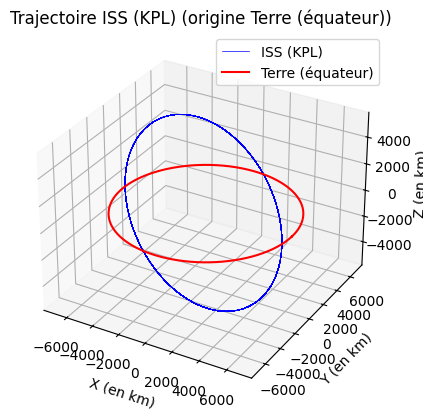

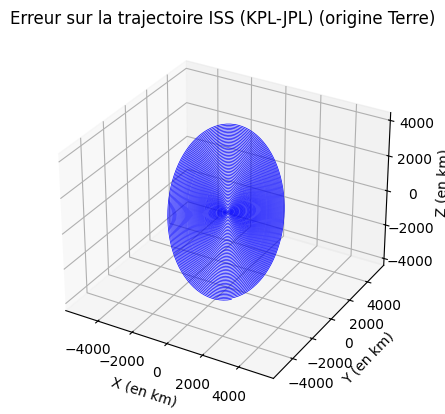

In [4]:
# Lancement du calcul Képler
XYZ_KPL = orbite_kepler(y0[0:3], y0[3:6], mu, t)
trace3D_traj('Terre (équateur)', 'ISS (KPL)', XYZ_KPL, RT)
trace3D_err('Terre', 'ISS (KPL-JPL)', XYZ_KPL-XYZ_JPL)

## Simulation numérique de l'orbite de Kepler

Cette modélisation sommaire permet cependant de valider la méthode de résolution numérique de l'équation différentielle. Cette méthode associée à ce modèle aboutit à une erreur de l'ordre de 50 cm !

début de la simulation numérique (KPL)
fin de la simulation à 0:00:05.865268 (hh:mm:ss.ms)


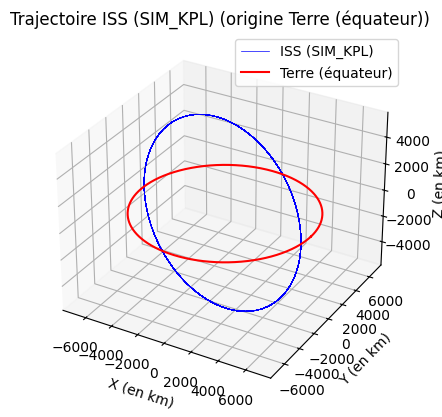

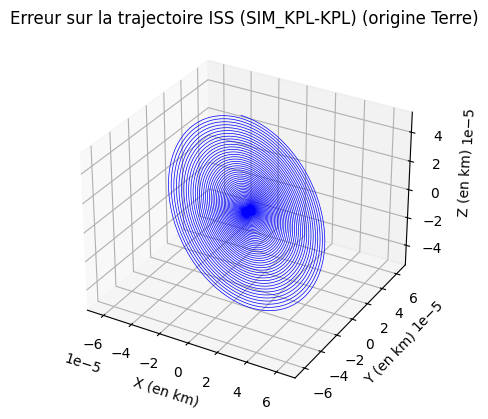

In [5]:
print('début de la simulation numérique (KPL)')
start = datetime.now()
_, y = meth(lambda _, y: equ_dyn(y, mu, termeJ2 = False), t, y0)
end = datetime.now()
print(f'fin de la simulation à {end - start} (hh:mm:ss.ms)')
XYZ_SIM_KPL = y[:, 0:3]
trace3D_traj('Terre (équateur)', 'ISS (SIM_KPL)', XYZ_SIM_KPL, RT)
trace3D_err('Terre', 'ISS (SIM_KPL-KPL)', XYZ_SIM_KPL-XYZ_KPL)

## Simulation plus élaborée de la trajectoire de l'ISS

Le modèle plus élaboré avec une Terre ellipsoïdale rend mieux compte de la trajectoire de l'ISS. L'erreur qui subsiste reste cependant de l'ordre de 100 km au bout de 4 jours. Il faudrait affiner la modélisation du potentiel gravitationnel pour une prédiction plus précise, mais l'idée ici est de montrer qu'un modèle "Terre sphérique" est insuffisant !

début de la simulation numérique (JPL)
fin de la simulation à 0:00:06.108949 (hh:mm:ss.ms)


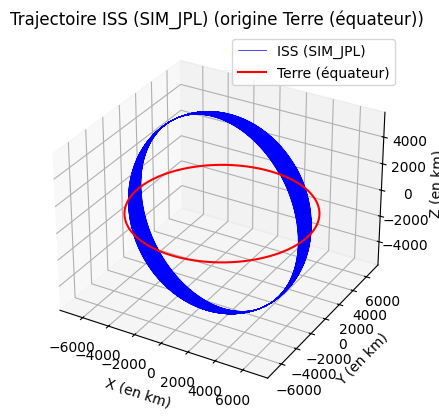

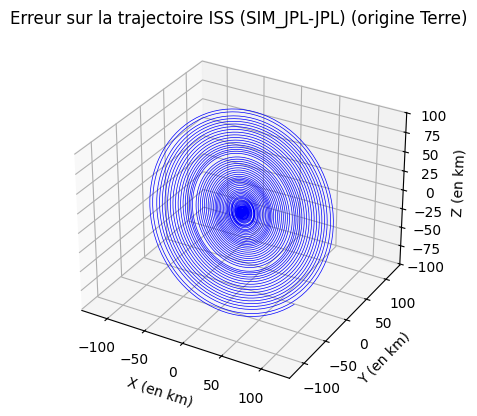

In [6]:
# Lancement de la simulation numérique
print('début de la simulation numérique (JPL)')
start = datetime.now()
_, y = meth(lambda _, y: equ_dyn(y, mu, termeJ2 = True), t, y0)
end = datetime.now()
print(f'fin de la simulation à {end - start} (hh:mm:ss.ms)')
DATA_SIM_JPL = y
XYZ_SIM_JPL = y[:, 0:3]
trace3D_traj('Terre (équateur)', 'ISS (SIM_JPL)', XYZ_SIM_JPL, RT)
trace3D_err('Terre', 'ISS (SIM_JPL-JPL)', XYZ_SIM_JPL-XYZ_JPL)

## Comparaison des paramètres orbitaux

Le modéle "Terre ellipsoïdale" proposé rend déjà bien compte des variations des paramètres orbitaux, qui resteraient constants avec un modèle "Terre sphérique". En particulier, la simulation numérique confirme que la longitude du noeud ascendant diminue d'environ 5° par jour, ce qui n'est pas négligeable.

La Terre n'est donc pas sphérique, comme annoncé !

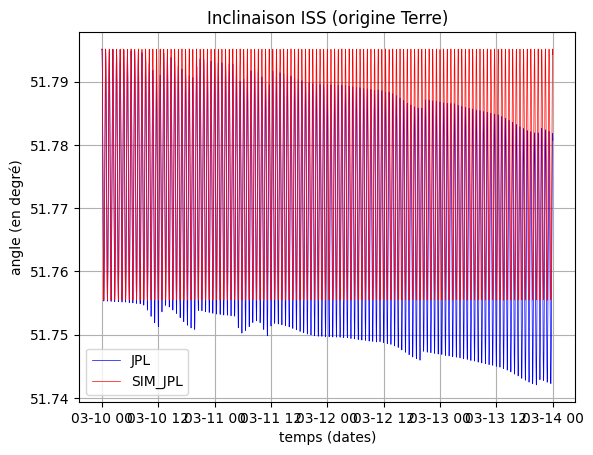

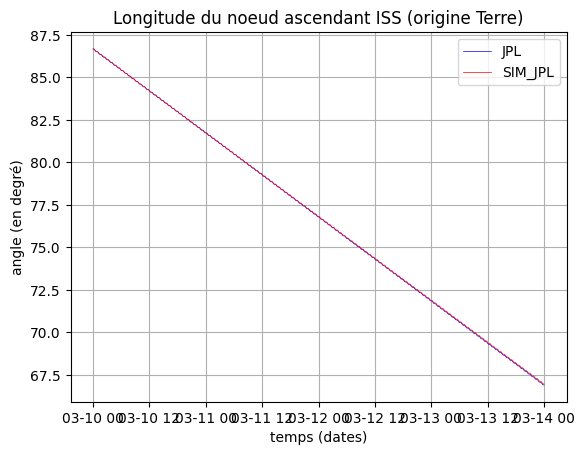

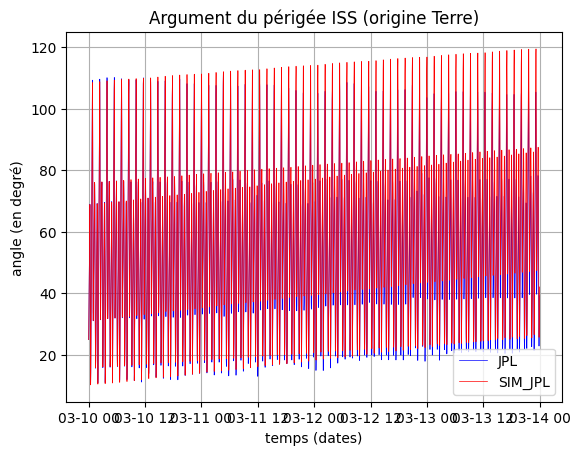

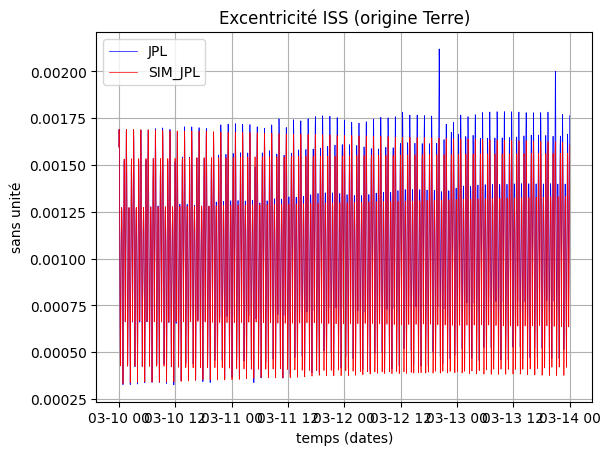

In [7]:
e_JPL, i_JPL, Omega_JPL, omega_JPL = calc_param_orb(
    DATA_JPL[:, 0:3], DATA_JPL[:, 3:6], mu)
e_SIM, i_SIM, Omega_SIM, omega_SIM = calc_param_orb(
    DATA_SIM_JPL[:, 0:3], DATA_SIM_JPL[:, 3:6], mu)
trace_param_orb('Inclinaison', 'angle (en degré)', 'Terre', 'ISS',
                i_JPL, i_SIM, 'JPL', 'SIM_JPL', dates, dates)
trace_param_orb('Longitude du noeud ascendant', 'angle (en degré)', 'Terre', 'ISS',
                Omega_JPL, Omega_SIM, 'JPL', 'SIM_JPL', dates, dates)
trace_param_orb('Argument du périgée', 'angle (en degré)', 'Terre', 'ISS',
                omega_JPL, omega_SIM, 'JPL', 'SIM_JPL', dates, dates)
trace_param_orb('Excentricité', 'sans unité', 'Terre', 'ISS',
                norm(e_JPL, axis=1), norm(e_SIM, axis=1), 'JPL', 'SIM_JPL', dates, dates)